In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage import gaussian_filter1d, median_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import os

In [2]:
filename_list = [
                #  './data_MeanRelativeChange/MeanRelativeChange_SDS.dat', # SDS
                 './data_MeanRelativeChange/MeanRelativeChange_23463-4m12a-t3.dat', # P3AT 
                 './data_MeanRelativeChange/MeanRelativeChange_22386-9m15a-CVWLM2.dat', # CTAB/NaSal $\alpha=0.95$
                 './data_MeanRelativeChange/MeanRelativeChange_22386-9m15a-CVWLM7.dat', # CTAB/NaSal $\alpha=0.7$
                 './data_MeanRelativeChange/MeanRelativeChange_22170-8m8a-S5A.dat', # Peptoid Amphiphile
                 './data_MeanRelativeChange/MeanRelativeChange_22170-8m8a-S3A.dat', # Peptoid Amphiphile
                 './data_MeanRelativeChange/MeanRelativeChange_22193-9m15a-ws1.dat', # Peptoid Amphiphile
                 './data_MeanRelativeChange/MeanRelativeChange_22193-9m15a-ws2.dat', # g
                 './data_MeanRelativeChange/MeanRelativeChange_22193-9m15a-ws3.dat', # h
                 './data_MeanRelativeChange/MeanRelativeChange_22193-9m15a-ws4.dat', # i
                 './data_MeanRelativeChange/MeanRelativeChange_22193-9m15a-ws5.dat', # j
                 './data_MeanRelativeChange/MeanRelativeChange_22193-9m15a-ws6.dat', # k
                 './data_MeanRelativeChange/MeanRelativeChange_25953-9m15a-9.dat', # l
                 ]

labels_list = [
    # 'SDS', 
    'P3AT', 
    r'CTAB/NaSal $\alpha=0.95$', 
    r'CTAB/NaSal $\alpha=0.7$', 
    'Peptoid Amphiphile S5A',
    'Peptoid Amphiphile S3A',
    'DNA/Surfactant Complex ws1',
    'DNA/Surfactant Complex ws2',
    'DNA/Surfactant Complex ws1',
    'DNA/Surfactant Complex ws4',
    'DNA/Surfactant Complex ws5',
    'DNA/Surfactant Complex ws6',
    'PAMAM/DBSA'
]

colors_list = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15']
markers_list = ['o', 's', '^', 'D', 'v', 'x', 'P', '*', 'H', 'h', '+', 'X', '|', '_']

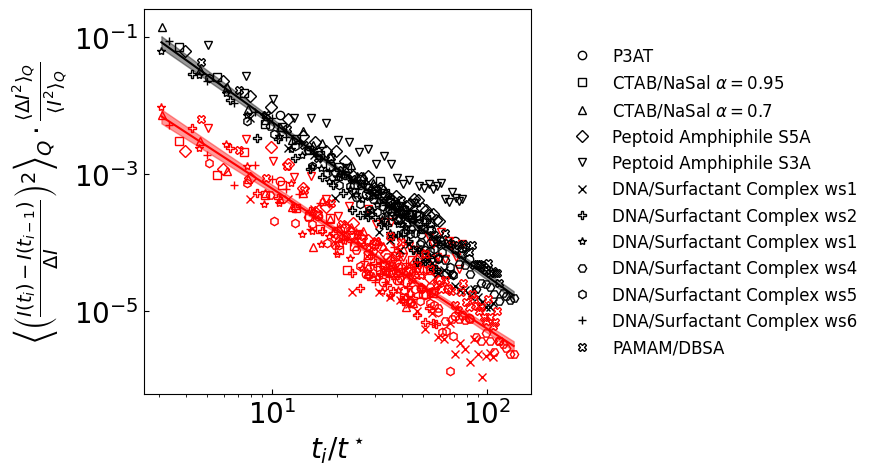

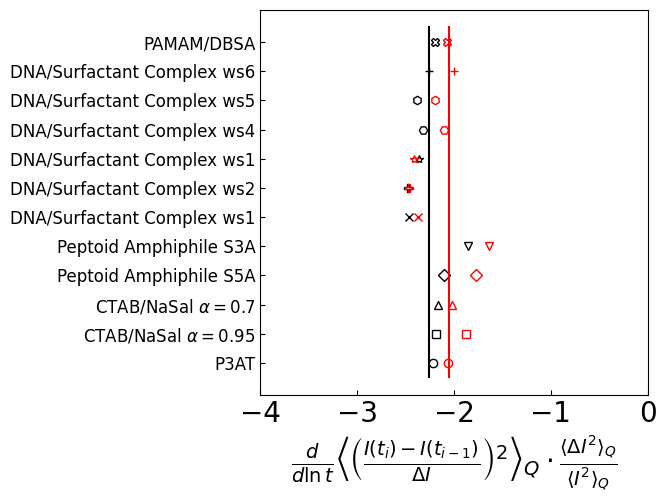

In [11]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

fig2 = plt.figure(figsize=(5, 5))
ax2 = plt.subplot(1, 1, 1)

time_all = []
time_1_all = []
time_1_exp_all = []
mse_all = []
mse_exp_all = []

for i_f, filename in enumerate(filename_list):
    data = np.loadtxt(filename)
    time = data[:, 0]
    mse = data[:, 1]
    mse_exp = data[:, 2]
    
    
    log_time = np.log(time)
    log_mse = np.log(mse)
    log_mse_exp = np.log(mse_exp)
    
    # Prepare the X matrix with ones and log_time
    X = np.vstack([np.ones_like(log_time), log_time]).T
    
    # Solve for coefficients using least squares
    A, _, _, _ = np.linalg.lstsq(X, log_mse, rcond=None)
    A_exp, _, _, _ = np.linalg.lstsq(X, log_mse_exp, rcond=None)
    
    # find the time where mse is 1
    time_1 = np.exp(-A[0] / A[1])
    
    # A contains the intercept and slope
    intercept, slope = A
    intercept_exp, slope_exp = A_exp
    
    time_1_exp = np.exp(-A_exp[0] / A_exp[1])
    
    # plot the data
    ax.plot(time/time_1_exp, mse, markers_list[i_f], color='r', markersize=6, fillstyle='none', alpha=1)
    ax.plot(time/time_1_exp, mse_exp, markers_list[i_f], color='k', markersize=6, fillstyle='none', alpha=1, label=labels_list[i_f])
    
    # # plot the fit
    # ax.plot(time/time_1_exp, np.exp(intercept + slope * log_time), color='r', alpha=0.5)
    # ax.plot(time/time_1_exp, np.exp(intercept_exp + slope_exp * log_time), color='k', alpha=0.5)
    
    # plot the fit slope
    ax2.plot(slope_exp, i_f, markers_list[i_f], color='k', markersize=6, fillstyle='none', alpha=1)
    ax2.plot(slope, i_f, markers_list[i_f], color='r', markersize=6, fillstyle='none', alpha=1)
    
    time_all.append(time)
    time_1_all.append(time_1)
    time_1_exp_all.append(time_1_exp)
    mse_all.append(mse)
    mse_exp_all.append(mse_exp)
    
time_normalized_exp = [time/t1 for time, t1 in zip(time_all, time_1_exp_all)]
time_normalized_exp = np.concatenate(time_normalized_exp)

# concatenate all data
time_all = np.concatenate(time_all)
time_1_all = np.array(time_1_all)
time_1_exp_all = np.array(time_1_exp_all)
mse_all = np.concatenate(mse_all)
mse_exp_all = np.concatenate(mse_exp_all)

# Sort data according to time_normalized_exp
sorted_indices = np.argsort(time_normalized_exp)
time_normalized_exp_sorted = time_normalized_exp[sorted_indices]
mse_exp_all_sorted = mse_exp_all[sorted_indices]
mse_all_sorted = mse_all[sorted_indices]

# Fit a linear model to the log-log data
log_time_normalized_exp = np.log(time_normalized_exp_sorted)
log_mse_exp_all = np.log(mse_exp_all_sorted)
log_mse_all = np.log(mse_all_sorted)
X_all = np.vstack([np.ones_like(log_time_normalized_exp), log_time_normalized_exp]).T

# Fit and compute covariance
A_exp_all, _, _, _ = np.linalg.lstsq(X_all, log_mse_exp_all, rcond=None)
A_all, _, _, _ = np.linalg.lstsq(X_all, log_mse_all, rcond=None)

# Predicted log-values
y_pred_exp = X_all @ A_exp_all
y_pred = X_all @ A_all

# Residual variance
resid_var_exp = np.var(log_mse_exp_all - y_pred_exp)
resid_var = np.var(log_mse_all - y_pred)

# Covariance matrices of parameters
cov_A_exp = resid_var_exp * np.linalg.inv(X_all.T @ X_all)
cov_A = resid_var * np.linalg.inv(X_all.T @ X_all)

# 95% confidence level
z_val = 1.96  # for approx 95% confidence interval

# Confidence interval (CI): only model uncertainty
ci_std_exp = np.sqrt(np.sum(X_all @ cov_A_exp * X_all, axis=1))
ci_std = np.sqrt(np.sum(X_all @ cov_A * X_all, axis=1))
upper_ci_exp = y_pred_exp + z_val * ci_std_exp
lower_ci_exp = y_pred_exp - z_val * ci_std_exp
upper_ci = y_pred + z_val * ci_std
lower_ci = y_pred - z_val * ci_std

# Prediction interval (PI): model + data uncertainty
pi_std_exp = np.sqrt(resid_var_exp + ci_std_exp**2)
pi_std = np.sqrt(resid_var + ci_std**2)
upper_pi_exp = y_pred_exp + z_val * pi_std_exp
lower_pi_exp = y_pred_exp - z_val * pi_std_exp
upper_pi = y_pred + z_val * pi_std
lower_pi = y_pred - z_val * pi_std

# Plot CI and PI
ax.fill_between(time_normalized_exp_sorted, np.exp(lower_ci_exp), np.exp(upper_ci_exp), color='k', alpha=0.4)
# ax.fill_between(time_normalized_exp_sorted, np.exp(lower_pi_exp), np.exp(upper_pi_exp), color='k', alpha=0.2)
ax.fill_between(time_normalized_exp_sorted, np.exp(lower_ci), np.exp(upper_ci), color='r', alpha=0.4)
# ax.fill_between(time_normalized_exp_sorted, np.exp(lower_pi), np.exp(upper_pi), color='r', alpha=0.2)



# plot the fit
ax.plot(time_normalized_exp_sorted, np.exp(y_pred_exp), color='k', alpha=1)
ax.plot(time_normalized_exp_sorted, np.exp(y_pred), color='r', alpha=1)

ax.set_xlabel(r'$t_i/t^\star$', fontsize=20)
ax.set_ylabel(r'$\left\langle \left( \frac{I(t_i) - I(t_{i-1})}{\Delta I} \right)^2 \right\rangle_Q \cdot \frac{ \left\langle \Delta I^2 \right\rangle_Q }{ \left\langle I^2 \right\rangle_Q }$', fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(direction='in', labelsize=20)
ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12)

# plot the slope of all data fit
ax2.plot([A_exp_all[1],A_exp_all[1]], [-0.5,len(filename_list)-0.5], '-', color='k', markersize=10, fillstyle='none', alpha=1)
ax2.plot([A_all[1],A_all[1]], [0-0.5,len(filename_list)-0.5], '-', color='r', markersize=10, fillstyle='none', alpha=1)

ax2.set_xlim([-4,0])
ax2.set_yticks(np.arange(len(filename_list)), labels_list, fontsize=12)
ax2.set_yticklabels(labels_list)
ax2.set_xlabel(r'$\frac{d}{d \ln t} \left\langle \left( \frac{I(t_i) - I(t_{i-1})}{\Delta I} \right)^2 \right\rangle_Q \cdot \frac{ \left\langle \Delta I^2 \right\rangle_Q }{ \left\langle I^2 \right\rangle_Q } $', fontsize=20)
ax2.tick_params(direction='in', labelsize=20)
ax2.tick_params(axis='y', labelsize=12)
